<a href="https://colab.research.google.com/github/SWS-swapnilsingh/Community-Classroom-OP/blob/main/MLP_Linear_Regression_on_California_housing_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression on California housing Dataset

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import loguniform
from scipy.stats import uniform

from sklearn.datasets import fetch_california_housing
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


Common set up

In [2]:
np.random.seed(306)

In [3]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [4]:
# Data Loading and splitting
# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(
    features, labels, random_state=42)
# we will hold this test data
# here com means combined train and validation dataset

# train --> train + dev split   #here dev means development set
train_features, dev_features, train_labels, dev_labels = train_test_split(
    com_train_features, com_train_labels, random_state=42)


In [5]:
# Linear regression with normal equation
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("lin_reg", LinearRegression())])
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)
lin_reg_train_error = -1 * lin_reg_cv_results['train_score']
lin_reg_test_error = -1 * lin_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lin_reg_train_error.mean():.3f} +/- {lin_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lin_reg_test_error.mean():.3f} +/- {lin_reg_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
0.530 +/- 0.002
Mean absolute error of linear regression model on the test set:
0.527 +/- 0.008


Both the errors are close, but are not low. This points to underfitting. We can address it by adding more feature through polynomial regression.

In [6]:
# Linear regression with SGD
sgd_reg_pipeline = Pipeline([("feature_scaling", StandardScaler()),
                             ("sgd_reg", SGDRegressor(
                                 max_iter=int(np.ceil(
                                     1e6/com_train_features.shape[0])),
                                 early_stopping=True,
                                 eta0=1e-4,
                                 learning_rate='constant',
                                 tol=1e-5,
                                 validation_fraction=0.1,
                                 n_iter_no_change=5,
                                 average=10,
                                 random_state=42))])

sgd_reg_cv_results = cross_validate(sgd_reg_pipeline,
                                    com_train_features,
                                    com_train_labels,
                                    cv=cv,
                                    scoring="neg_mean_absolute_error",
                                    return_train_score=True,
                                    return_estimator=True)

sgd_train_error = -1 * sgd_reg_cv_results['train_score']
sgd_test_error = -1 * sgd_reg_cv_results['test_score']

print(f"Mean absolute error of SGD regression model on the train set:\n"
      f"{sgd_train_error.mean():.3f} +/- {sgd_train_error.std():.3f}")
print(f"Mean absolute error of SGD regression model on the test set:\n"
      f"{sgd_test_error.mean():.3f} +/- {sgd_test_error.std():.3f}")

Mean absolute error of SGD regression model on the train set:
0.534 +/- 0.013
Mean absolute error of SGD regression model on the test set:
0.530 +/- 0.010


# Polynomial regression
We will train a polynomial model with degree 2 and alter we will use `validation_curve` to find out right degree to use for polynomial models

In [7]:
poly_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                              ("feature_scaling", StandardScaler()),
                              ("lin_reg", LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring="neg_mean_absolute_error",
                                     return_train_score=True,
                                     return_estimator=True)
poly_train_error = -1 * poly_reg_cv_results['train_score']
poly_test_error = -1 * poly_reg_cv_results['test_score']

print(f"Mean absolute error of polynomial regression model on the train set:\n"
      f"{poly_train_error.mean():.3f} +/- {poly_train_error.std():.3f}")
print(f"Mean absolute error of polynomial regression model on the test set:\n"
      f"{poly_test_error.mean():.3f} +/- {poly_test_error.std():.3f}")


Mean absolute error of polynomial regression model on the train set:
0.461 +/- 0.003
Mean absolute error of polynomial regression model on the test set:
0.485 +/- 0.030


Instead of using all polynomial feature, we use only interaction feature terms in polynomial model and train the linear regression model.

In [8]:
poly_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2, interaction_only=True)),
                              ("feature_scaling", StandardScaler()),
                              ("lin_reg", LinearRegression())])
poly_reg_cv_results = cross_validate(poly_reg_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring="neg_mean_absolute_error",
                                     return_train_score=True,
                                     return_estimator=True)
poly_train_error = -1 * poly_reg_cv_results['train_score']
poly_test_error = -1 * poly_reg_cv_results['test_score']

print(f"Mean absolute error of polynomial regression model on the train set:\n"
      f"{poly_train_error.mean():.3f} +/- {poly_train_error.std():.3f}")
print(f"Mean absolute error of polynomial regression model on the test set:\n"
      f"{poly_test_error.mean():.3f} +/- {poly_test_error.std():.3f}")


Mean absolute error of polynomial regression model on the train set:
0.478 +/- 0.003
Mean absolute error of polynomial regression model on the test set:
0.497 +/- 0.024


Let's figure out which degree polynomial is better suited for the regression problem at out hand. For that we will use `validation_curve`, which can be considered as a manual hyperparameter tuning.
Here we specify a list of values that we want to try for polynomial degree and specify it as a parameter in `validation_curve`.

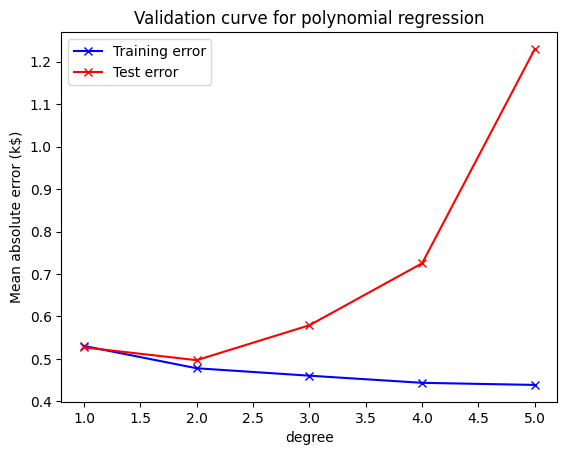

In [9]:
degree = [1, 2, 3, 4, 5]
train_scores, test_scores = validation_curve(
    poly_reg_pipeline, com_train_features, com_train_labels, param_name="poly__degree",
    param_range=degree, cv=cv, scoring="neg_mean_absolute_error",
    n_jobs=-1)

train_errors, test_errors = -train_scores, -test_scores
plt.plot(degree, train_errors.mean(axis=1), 'b-x', label="Training error")
plt.plot(degree, test_errors.mean(axis=1), 'r-x', label="Test error")
plt.legend()

plt.xlabel("degree")
plt.ylabel("Mean absolute error (k$)")
_= plt.title("Validation curve for polynomial regression")

# Ridge regression
The polynomial models have a tendency to overfit-if we use higher order plynomial features. We will use `Ridge` regression-which penalizes for excessive model complexity in the plynomial regression by adding a regularization term.

In [10]:
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("ridge", Ridge(alpha=0.5))])
ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

print(f"Mean absolute error of ridge regression model (alpha=0.5) on the train set:\n"
      f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of ridge regression model (alpha=0.5) on the test set:\n"
      f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")

Mean absolute error of ridge regression model (alpha=0.5) on the train set:
0.481 +/- 0.003
Mean absolute error of ridge regression model (alpha=0.5) on the test set:
0.487 +/- 0.006


# HPT for ridge regularization rate

In [11]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("ridge_cv", RidgeCV(alphas=alpha_list,
                                                    cv=cv,
                                                    scoring="neg_mean_absolute_error"))])
ridge_reg_cv_results = ridge_reg_pipeline.fit(com_train_features, com_train_labels)

print("The score with the best alpha is:",
      f"{ridge_reg_cv_results[-1].best_score_:.3f}")
print("The error with the best alpha is:",
      f"{-ridge_reg_cv_results[-1].best_score_:.3f}")
print("The best value for alpha:", ridge_reg_cv_results[-1].alpha_)


The score with the best alpha is: -0.473
The error with the best alpha is: 0.473
The best value for alpha: 0.007847599703514606


#`RidgeCV` with cross validation

In [12]:
alpha_list = np.logspace(-4, 0, num=20)
ridge_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("ridge_cv", RidgeCV(alphas=alpha_list,
                                                    store_cv_values=True))])

ridge_reg_cv_results = cross_validate(ridge_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)

ridge_reg_train_error = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_error = -1 * ridge_reg_cv_results['test_score']

print(f"Mean absolute error of ridge regression model on the train set:\n"
      f"{ridge_reg_train_error.mean():.3f} +/- {ridge_reg_train_error.std():.3f}")
print(f"Mean absolute error of ridge regression model on the test set:\n"
      f"{ridge_reg_test_error.mean():.3f} +/- {ridge_reg_test_error.std():.3f}")


Mean absolute error of ridge regression model on the train set:
0.470 +/- 0.011
Mean absolute error of ridge regression model on the test set:
0.474 +/- 0.011


Let's look at the mean of mean abolute errors at different values of regularization rate across diffeent cross validation folds.

In [13]:
#rough cell
# len(alpha_list)
# alpha_list
len(ridge_reg_cv_results["estimator"])
print(ridge_reg_cv_results["estimator"][0][-1].cv_values_)

[[1.40511462 1.40163552 1.39624769 ... 0.02690945 0.00212132 0.00225279]
 [0.45429241 0.45376557 0.45298836 ... 0.3920507  0.38689402 0.38361883]
 [0.20170316 0.20278323 0.20440218 ... 0.42407814 0.4494925  0.47137614]
 ...
 [0.05237336 0.05205942 0.05162389 ... 0.09181651 0.09609176 0.10000975]
 [0.07486345 0.07476515 0.07461235 ... 0.08881189 0.09397775 0.09853275]
 [0.61458345 0.61427159 0.61387471 ... 0.75765745 0.7711293  0.7822217 ]]


In [14]:
#rough cell
# RidgeCV?
len(com_train_features)*0.8

12384.0

In [15]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)  for est in ridge_reg_cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alpha_list)
cv_alphas

,0.000100,0.000162,0.000264,0.000428,0.000695,0.001129,0.001833,0.002976,0.004833,0.007848,0.012743,0.020691,0.033598,0.054556,0.088587,0.143845,0.233572,0.379269,0.615848,1.000000
0,79.825105,83.556979,89.052274,96.713331,106.577419,117.958587,129.309233,138.553544,143.696595,143.239843,136.323827,122.943609,104.328753,82.970054,61.840053,43.298869,28.559398,17.803633,10.526486,5.909713
1,14.065799,13.742714,13.245802,12.504952,11.450787,10.048351,8.345884,6.505474,4.765508,3.333758,2.295126,1.610844,1.183945,0.919624,0.750990,0.641272,0.577008,0.556458,0.575055,0.616682
2,5.267710,5.272331,5.279626,5.290956,5.308105,5.333104,5.367714,5.412616,5.466685,5.526801,5.588436,5.647108,5.700570,5.751087,5.806722,5.879665,5.978467,6.094229,6.190664,6.210415
3,5.853085,5.867043,5.888945,5.922643,5.972982,6.045051,6.142429,6.264704,6.405584,6.553176,6.692444,6.808469,6.889793,6.931979,6.940661,6.931633,6.923902,6.924670,6.915607,6.852967
4,8.134646,7.993974,7.781172,7.471108,7.042443,6.489075,5.830605,5.110992,4.379774,3.666586,2.970194,2.275449,1.595598,1.021163,0.731173,0.912456,1.609059,2.646320,3.729320,4.609697
5,66.100008,60.047159,52.002193,42.279138,31.879141,22.232981,14.513912,9.100108,5.651189,3.553748,2.267632,1.438728,0.884846,0.552525,0.464962,0.651161,1.080903,1.657819,2.268932,2.827886
6,2.309882,2.253722,2.168544,2.044094,1.871808,1.650275,1.391207,1.120910,0.873056,0.675781,0.543603,0.482411,0.504610,0.643451,0.952959,1.480223,2.215475,3.063332,3.875894,4.520391
7,19.019937,20.494095,22.742542,26.033396,30.548208,36.182667,42.368884,48.126041,52.384040,54.327657,53.538865,50.004599,44.134732,36.750467,28.898463,21.529074,15.270441,10.392246,6.862006,4.445108
8,4.351827,4.345297,4.335085,4.319448,4.296236,4.263277,4.219299,4.165380,4.106281,4.050251,4.006641,3.983150,3.985501,4.019862,4.095335,4.222623,4.405521,4.627181,4.842507,4.987779
9,3.963850,3.952362,3.934504,3.907436,3.867958,3.813571,3.744526,3.666285,3.590431,3.532157,3.505531,3.520803,3.586362,3.713344,3.917635,4.213494,4.596544,5.025147,5.419899,5.688782


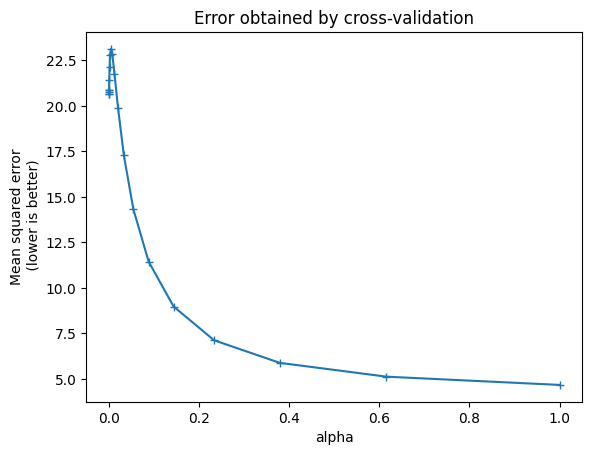

In [16]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

In [17]:
best_alphas = [est[-1].alpha_ for est in ridge_reg_cv_results["estimator"]]
best_alphas

[1.0,
 0.37926901907322463,
 9.999999999999999e-05,
 9.999999999999999e-05,
 0.08858667904100824,
 0.08858667904100824,
 0.0206913808111479,
 1.0,
 0.0206913808111479,
 0.012742749857031334]

The optimal regularization strength is not necessarily the on cross-validation iterations. But since we expect each cross-validation resampling to stem from the same data distribution, it is common practice to use the average value of the best alha found on different cross-validation folds as our final estimate for the tuned alpha.

In [18]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.26 +/- 0.38


# Ridge HPT through `GridSearchCV`

In [19]:
ridge_grid_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                                ("feature_scaling", StandardScaler()),
                                ("ridge", Ridge())])
param_grid = {'poly__degree': (1, 2, 3),
              'ridge__alpha': np.logspace(-4, 0, num=20)}
ridge_grid_search = GridSearchCV(ridge_grid_pipeline,
                                  param_grid=param_grid,
                                  n_jobs=2,
                                  cv=cv,
                                  scoring="neg_mean_absolute_error",
                                  return_train_score=True)
print(ridge_grid_search.fit(com_train_features, com_train_labels))

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'poly__degree': (1, 2, 3),
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')


`ridge_grid_search.best_index_` gives us the index of the best parameter in the list.

In [20]:
mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]
std_train_error = ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
std_test_error = ridge_grid_search.cv_results_['std_test_score'][ridge_grid_search.best_index_]

print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of polynomial ridge regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial ridge regression model on the train set:
0.463 +/- 0.004
Mean absolute error of polynomial ridge regression model on the test set:
0.474 +/- 0.015


In [21]:
print("Mean cross validated score of the best estimator is: ", ridge_grid_search.best_score_)
print("Mean cross validated error of the best estimator is: ", -ridge_grid_search.best_score_)

Mean cross validated score of the best estimator is:  -0.4738651177010773
Mean cross validated error of the best estimator is:  0.4738651177010773


Note that this is same as `RidgeCV` that we carried out earlier

In [22]:
print("The best parameter value is:", ridge_grid_search.best_params_)

The best parameter value is: {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


# Lasso regression

## Baseline model with fixed learning rate

In [23]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("lasso", Lasso(alpha=0.01))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)

lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lasso_reg_train_error.mean():.3f} +/- {lasso_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lasso_reg_test_error.mean():.3f} +/- {lasso_reg_test_error.std():.3f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e+01, tolerance: 1.654e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e+01, tolerance: 1.669e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e+01, tolerance: 1.658e

Mean absolute error of linear regression model on the train set:
0.529 +/- 0.003
Mean absolute error of linear regression model on the test set:
0.528 +/- 0.008


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e+01, tolerance: 1.658e+00
  model = cd_fast.enet_coordinate_descent(


# HPT for lasso regularization rate

## With cross validation

In [24]:
alpha_list = np.logspace(-6, 0, num=20)
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("lasso_cv", LassoCV(alphas=alpha_list, cv=cv))])
lasso_reg_cv_results = cross_validate(lasso_reg_pipeline,
                                      com_train_features,
                                      com_train_labels,
                                      cv=cv,
                                      scoring="neg_mean_absolute_error",
                                      return_train_score=True,
                                      return_estimator=True)

lasso_reg_train_error = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_error = -1 * lasso_reg_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{lasso_reg_train_error.mean():.3f} +/- {lasso_reg_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{lasso_reg_test_error.mean():.3f} +/- {lasso_reg_test_error.std():.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4040323870094653, tolerance: 1.3364869834102637
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.942302490010661, tolerance: 1.3364869834102637
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.597153668762985, tolerance: 1.3364869834102637
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergenc

Mean absolute error of linear regression model on the train set:
0.524 +/- 0.015
Mean absolute error of linear regression model on the test set:
0.524 +/- 0.013


In [25]:
best_alphas = [est[-1].alpha_ for est in lasso_reg_cv_results["estimator"]]
best_alphas

[0.01274274985703132,
 0.01274274985703132,
 0.00615848211066026,
 0.00615848211066026,
 0.00615848211066026,
 1e-06,
 0.01274274985703132,
 0.0003359818286283781,
 0.00615848211066026,
 0.02636650898730355]

In [26]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
      f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.01 +/- 0.01


In [27]:
lasso_reg_pipeline = Pipeline([("poly", PolynomialFeatures(degree=2)),
                               ("feature_scaling", StandardScaler()),
                               ("lasso", Lasso(alpha=0.01))])
lasso_reg_pipeline.fit(com_train_features, com_train_labels)
train_error = mean_absolute_error(com_train_labels, lasso_reg_pipeline.predict(com_train_features))

print(f"Mean absolute error of Lasso CV model on the train set:", train_error)

Mean absolute error of Lasso CV model on the train set: 0.5291330037868303


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.759e+01, tolerance: 2.066e+00
  model = cd_fast.enet_coordinate_descent(


# With GridSearchCV

In [29]:
lasso_grid_pipeline = Pipeline([("poly", PolynomialFeatures()),
                              ("feature_scaling", StandardScaler()),
                              ("lasso", Lasso())])

param_grid = {'poly__degree': (1, 2, 3),
              'lasso__alpha': np.logspace(-4, 0, num=20)}
lasso_grid_search = GridSearchCV(lasso_grid_pipeline,
                                 param_grid=param_grid,
                                 n_jobs=2,
                                 cv=cv,
                                 scoring="neg_mean_absolute_error",
                                 return_train_score=True)
lasso_grid_search.fit(com_train_features, com_train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.638e+03, tolerance: 2.066e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaling', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=2,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         'poly__degree': (1, 2, 3)},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [37]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]
std_train_error = lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]
std_test_error = lasso_grid_search.cv_results_['std_test_score'][lasso_grid_search.best_index_]

print(f"Best Mean absolute error of polynomial ridge regression model on the train set:\n"
      f"{mean_train_error:.3f} +/- {std_train_error:.3f}")
print(f"Mean absolute error of polynomial ridge regression model on the test set:\n"
      f"{mean_test_error:.3f} +/- {std_test_error:.3f}")

Best Mean absolute error of polynomial ridge regression model on the train set:
0.462 +/- 0.003
Mean absolute error of polynomial ridge regression model on the test set:
0.488 +/- 0.046


In [39]:
print("Mean cross validated score of the best estimator is: ", lasso_grid_search.best_score_)
print ("The best parameter value is: ", lasso_grid_search.best_params_)

Mean cross validated score of the best estimator is:  -0.48798304453391383
The best parameter value is:  {'lasso__alpha': 9.999999999999999e-05, 'poly__degree': 3}


# SGD: Regularization and HPT
We can also perform regularization with SGD. `SGDRegressor` has many hyperparameters that require careful tuning to achieve the same performance as with `LinearRegression`.

In [40]:
poly_sgd_pipeline = Pipeline([("poly", PolynomialFeatures()),
                              ("feature_scaling", StandardScaler()),
                              ("sgd_reg", SGDRegressor(
                                  penalty='elasticnet',
                                  random_state=42))])
poly_sgd_cv_results = cross_validate(poly_sgd_pipeline,
                                     com_train_features,
                                     com_train_labels,
                                     cv=cv,
                                     scoring="neg_mean_absolute_error",
                                     return_train_score=True,
                                     return_estimator=True)

poly_sgd_train_error = -1 * poly_sgd_cv_results['train_score']
poly_sgd_test_error = -1 * poly_sgd_cv_results['test_score']

print(f"Mean absolute error of linear regression model on the train set:\n"
      f"{poly_sgd_train_error.mean():.3f} +/- {poly_sgd_train_error.std():.3f}")
print(f"Mean absolute error of linear regression model on the test set:\n"
      f"{poly_sgd_test_error.mean():.3f} +/- {poly_sgd_test_error.std():.3f}")

Mean absolute error of linear regression model on the train set:
10824283052.546 +/- 4423288211.832
Mean absolute error of linear regression model on the test set:
10946788540.250 +/- 5396536227.703


Let's search for the best set of parameters for polynomial + SGD pipeline with `RandomizedSearchCV`.
>Remember in `RandomizedSearchCV`, we need to specify distributions for hyperparameters.

In [ ]:
class uniform_int:
  """Integer valued version of the uniform distribution"""
  def __init__(self, a, b):
    self._distribution = uniform(a, b)

  def rvs(self, *args, **kwargs):
    """Random variable sample"""
    return self._distribution.rvs(*args, **kwargs).astype(int)


In [41]:
param_distributions = {
    'poly__degree': [1, 2, 3],
    'sgd_reg__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'sgd_reg__l1_ratio': uniform(0, 1),
    'sgd_reg__eta0': loguniform(1e-5, 1),
    'sgd_reg__power_t': uniform(0, 1)
}

poly_sgd_random_search = RandomizedSearchCV(
    poly_sgd_pipeline,
    param_distributions=param_distributions,
    n_iter=10, cv=cv, verbose=1, scoring='neg_mean_absolute_error'
)
poly_sgd_random_search.fit(com_train_features, com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaling',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7be4091b0760>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7be4091b0190>,
                                        'sgd_reg__learning_rate': ['constant',
                                                                   'adaptive',
                                                                   'invscaling'],
                                        'sgd_reg__power_t': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7be4091b2230>},
                   scoring='neg_mean_absolute_error', verbose=1)

In [42]:
# The best score can be obtained as follows
poly_sgd_random_search.best_score_

-0.527301458558017

In [43]:
# The best set of parameters are obtained as follows
poly_sgd_random_search.best_params_

{'poly__degree': 1,
 'sgd_reg__eta0': 0.00015476270108098552,
 'sgd_reg__l1_ratio': 0.5485428561088888,
 'sgd_reg__learning_rate': 'constant',
 'sgd_reg__power_t': 0.4907965441139148}

And the best estimator can be accessed with `best_estimator_` member variable.

In [45]:
print(poly_sgd_random_search.best_estimator_)

Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('feature_scaling', StandardScaler()),
                ('sgd_reg',
                 SGDRegressor(eta0=0.00015476270108098552,
                              l1_ratio=0.5485428561088888,
                              learning_rate='constant', penalty='elasticnet',
                              power_t=0.4907965441139148, random_state=42))])


# Comparison of weight vectors

Let's look at the weight vectors produced by different models.

In [52]:
feature_names = poly_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns
)
print(feature_names) #this will print all the features including interaction features

['1' 'MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude' 'MedInc HouseAge' 'MedInc AveRooms'
 'MedInc AveBedrms' 'MedInc Population' 'MedInc AveOccup'
 'MedInc Latitude' 'MedInc Longitude' 'HouseAge AveRooms'
 'HouseAge AveBedrms' 'HouseAge Population' 'HouseAge AveOccup'
 'HouseAge Latitude' 'HouseAge Longitude' 'AveRooms AveBedrms'
 'AveRooms Population' 'AveRooms AveOccup' 'AveRooms Latitude'
 'AveRooms Longitude' 'AveBedrms Population' 'AveBedrms AveOccup'
 'AveBedrms Latitude' 'AveBedrms Longitude' 'Population AveOccup'
 'Population Latitude' 'Population Longitude' 'AveOccup Latitude'
 'AveOccup Longitude' 'Latitude Longitude']


In [54]:
coefs = [est[-1].coef_ for est in poly_reg_cv_results["estimator"]]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)

,1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedInc HouseAge,...,AveBedrms Population,AveBedrms AveOccup,AveBedrms Latitude,AveBedrms Longitude,Population AveOccup,Population Latitude,Population Longitude,AveOccup Latitude,AveOccup Longitude,Latitude Longitude
0,-1.204134e-12,-16.156937,-12.109238,11.123584,-9.446549,-2.349412,73.663576,1.635638,-0.468455,0.112528,...,0.520628,0.512439,-5.632365,-14.438934,1.305599,-0.526772,-2.359217,35.107815,110.727914,2.027539
1,-8.212826e-14,-17.003090,-11.743011,12.240445,-9.315909,-1.094189,2.493542,1.038381,0.041856,0.098081,...,0.744399,-0.848693,-4.627587,-13.522510,1.778046,0.451794,0.182027,8.974618,11.084415,1.079648
2,3.640341e-14,-17.900033,-12.257172,10.292853,-8.717071,-0.881034,23.213876,1.570528,-0.019249,0.107998,...,0.639221,-1.723384,-4.742485,-13.118958,2.930279,0.290336,0.044248,11.260718,35.417782,1.534567
3,-1.079120e-13,-17.145625,-12.473308,10.458968,-12.398535,-2.585756,21.584036,1.835444,0.185318,0.111686,...,0.713538,-1.591073,-6.040905,-17.985377,3.264050,-0.158931,-2.026762,11.681092,34.212814,1.665192
4,-2.616680e-14,-17.231805,-11.281427,12.972068,-10.580057,0.290007,-8.389704,1.306280,0.015908,0.124886,...,0.716458,-2.727109,-5.235846,-15.323436,4.166789,0.806603,1.812091,15.348392,6.225963,1.404725
5,-1.857407e-14,-16.967621,-12.078285,10.637864,-9.363588,-0.934352,-7.156921,1.383365,0.134383,0.067260,...,0.733430,0.171967,-5.035824,-13.797839,3.717242,0.322330,0.154641,11.850165,5.159429,1.308570
6,-9.705732e-16,-16.096650,-11.694402,9.244893,-8.305096,-1.201522,6.735455,1.574442,-0.030577,0.099345,...,0.792720,-0.862692,-4.354374,-12.233066,5.103570,0.536232,0.170972,12.126129,18.765997,1.635565
7,-3.097371e-13,-16.824910,-12.240819,10.083843,-9.021105,-2.780517,69.307327,1.095342,-0.207512,0.108252,...,0.538989,0.500744,-5.565988,-13.971894,1.174008,-0.563386,-2.848275,32.656333,103.697714,1.255188
8,-2.201521e-14,-17.224188,-13.640947,12.349428,-9.173223,-2.128355,15.575263,1.712271,-0.013705,0.112429,...,0.644535,-1.457915,-5.118972,-13.860902,2.924185,-0.037309,-1.511365,10.745372,27.127625,1.682981
9,-7.634839e-14,-17.556864,-12.153637,9.639207,-10.976056,-2.113511,14.670378,1.737920,0.168866,0.097472,...,0.687755,-1.745392,-5.813113,-16.342039,2.932580,-0.096506,-1.486584,11.682279,27.166416,1.597840


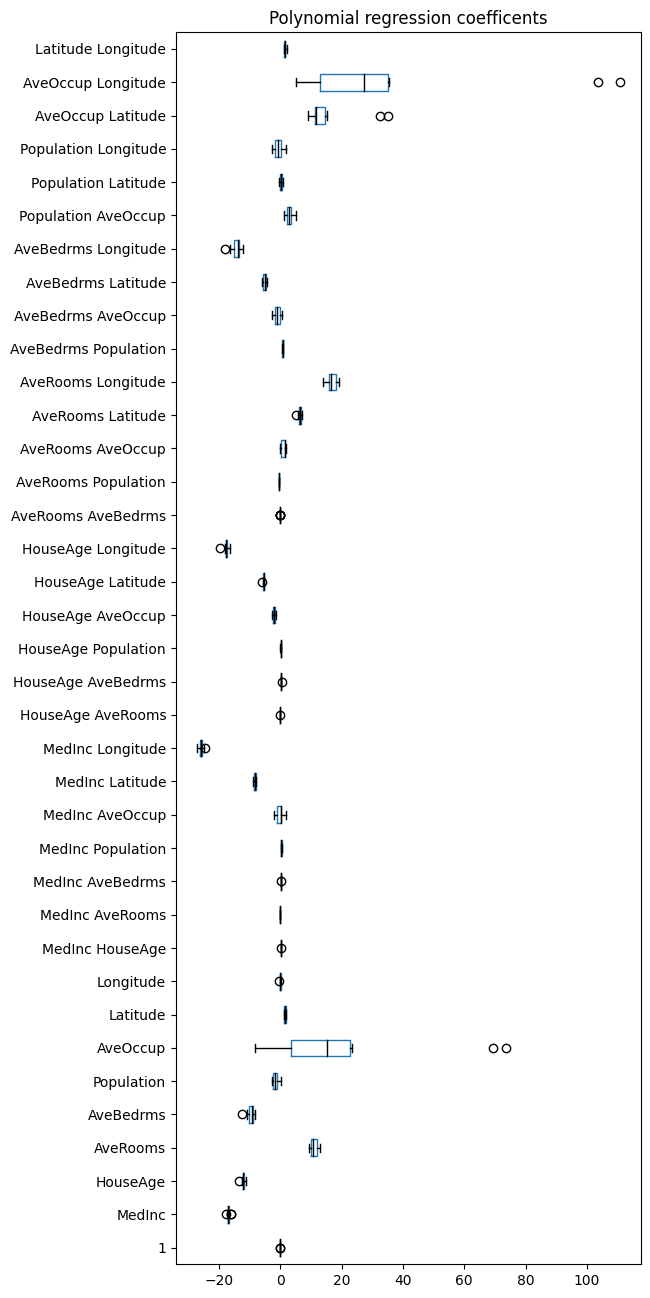

In [55]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_polynomial_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficents")

The weight values given to average occupancies are quite high. We can fix it, through ridge regression where you  will that the range is now more uniform

In [56]:
feature_names = ridge_reg_cv_results["estimator"][0][0].get_feature_names_out(
    input_features=train_features.columns)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [57]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_results["estimator"]]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

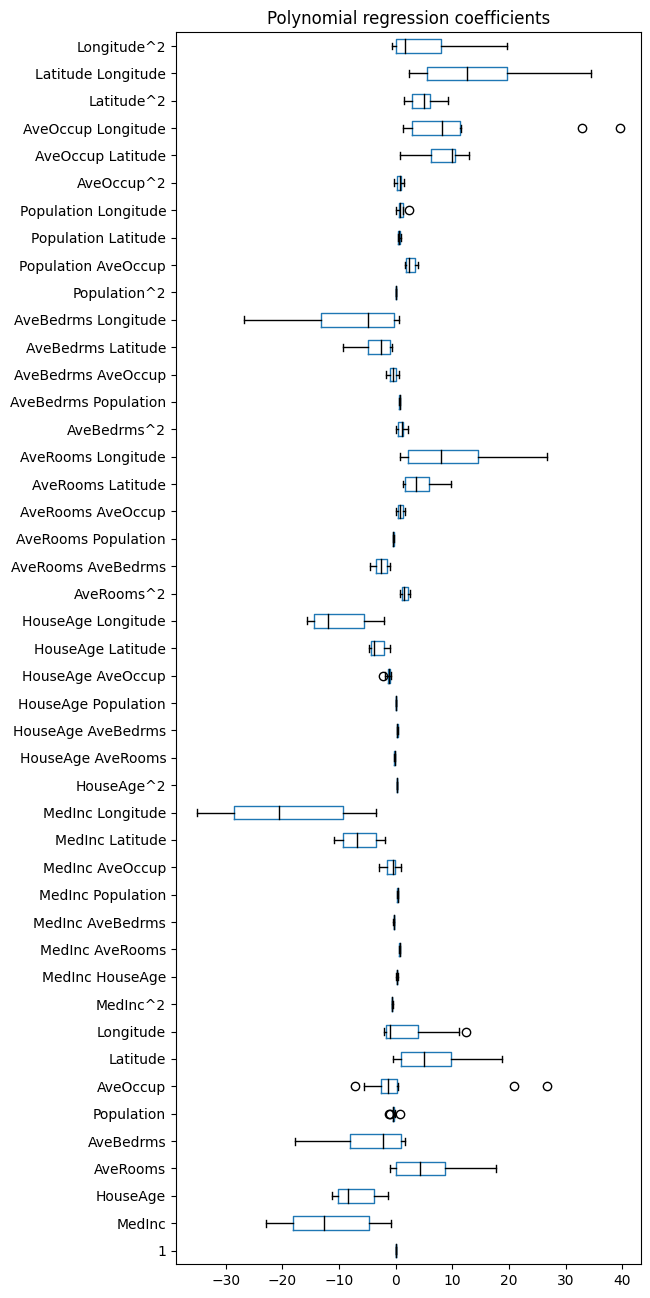

In [59]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_ridge_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Polynomial regression coefficients")

# Performance on the test set
Finally we can compare performance of different regression models

###Baseline

In [60]:
baseline_model_median = DummyRegressor(strategy="median")
baseline_model_median.fit(train_features, train_labels)
mean_absolute_percentage_error(test_labels, baseline_model_median.predict(test_features))

0.5348927548151625

### Linear regression with normal equation

In [62]:
mean_absolute_percentage_error(test_labels, lin_reg_cv_results['estimator'][0].predict(test_features))

0.321204721754829

In [65]:
mean_absolute_percentage_error(test_labels,
                               poly_sgd_random_search.best_estimator_.predict(
                                   test_features
                               ))

0.31853708738268754

### Polynomial regression

In [71]:
poly_reg_pipeline.fit(com_train_features, com_train_labels)
mean_absolute_percentage_error(test_labels,
                               poly_reg_pipeline.predict(test_features))

0.2819975908265711

### Ridge regression

In [73]:
mean_absolute_percentage_error(test_labels,
                               ridge_grid_search.best_estimator_.predict(test_features))

0.271103364513841

### Lasso regression

Let's retrain the lasso model with `alpha` identified through hyper-parameter and evaluate it on the test data.

In [74]:
mean_absolute_percentage_error(test_labels,
                               lasso_grid_search.best_estimator_.predict(test_features))

0.2807496926381012

Among these models ridge is seems to be performing well. So we can use ridge model for future predictions

## Summary
We trained multiple linear regressin models on housing dataset. Set their hyperparameters through hyper-parameter optimization.
Retrained models with the best values of hyper-parameters and then evaluated their performance on the test data (that was hold back until final evaluation).
this is how most of the real world problems are solved starting from simple models to more sophisticated models.